# Portfolio optimization: traditional, enhanced or naive?
- - -

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

from matplotlib.ticker import FuncFormatter
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from datetime import datetime

import yfinance as yf

import scipy.stats as scs
import scipy.optimize as sco
import scipy.interpolate as sci

import statsmodels.api as sm

import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import plotly.figure_factory as ff

import functions as fun

import os

In [3]:
def statistics(weights):
    
    weights = np.array(weights) 
    pret = np.sum(rets_mean * weights)
    pvol = np.sqrt(np.dot(weights.T, np.dot(sigma, weights)))
    
    return np.array([pret, pvol, pret / pvol])

def min_func_port(w):
    return statistics(w)[1]

def port_opt(rets_mean, sigma, noa, Rf):
   
    weights = np.zeros((2000,noa))
    for i in range(len(weights)):
        weights[i] = fun.rand_weights(noa)
    
    ex_weights = np.zeros((10000,noa))
    for i in range(len(ex_weights)):
        ex_weights[i] = fun.extreme_weights(noa)
    
    new_weights = np.concatenate((weights, ex_weights, np.identity(noa)))

    pret= fun.portf_mean(new_weights, rets_mean)
    pvol = np.sqrt(fun.portf_var(new_weights, sigma))
    
    trets = np.linspace(0, max(pret))
    tvols = []
    
    for tret in trets:
        bnds = tuple((0, 1) for x in range(noa))
        cons = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - tret}, 
                {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
        res = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',  
                           bounds=bnds, constraints=cons)
        tvols.append(res['fun'])
       
    tvols = np.array(tvols)
    
    ind = np.argmin(tvols)
    evols = tvols[ind:]
    erets = trets[ind:]

    tck = sci.splrep(evols, erets)
    
    Sr = []
    for sig, mu in zip(evols, sci.splev(evols, tck, der = 0)):
         Sr.append((mu - Rf)/sig)
        
    sigma_T = np.linspace(0.0, max(evols))
    E_T = Rf + max(Sr)*sigma_T

    TP = np.argmax(Sr)
    
    con = ({'type': 'eq', 'fun': lambda x:  statistics(x)[0] - erets[TP]}, 
            {'type': 'eq', 'fun': lambda x:  np.sum(x) - 1})
    solve = sco.minimize(min_func_port, noa * [1. / noa,], method='SLSQP',bounds=bnds, constraints=con)
    
    keys = rets_mean.index
    values = solve['x'].round(6)
    opt = {keys[i]: values[i] for i in range(len(keys))} 

    plt.figure(figsize=(22,9))

    # random portfolio composition
    plt.scatter(pvol, pret, marker= 'o', lw = 0.1, c = pret/pvol, edgecolors='w')

    # efficient frontier
    plt.plot(evols, erets, 'deeppink', lw=4, label='Efficient frontier')

    # capital market line
    plt.plot(sigma_T, E_T, lw = 3, label= 'Capital Market Line')

    # tangency portfolio
    plt.plot(evols[TP], erets[TP], 'y*', markersize=25.0, label='Tangency portfolio')
    
    plt.grid(True)
    plt.axhline(0, color='k', ls='--', lw=2.0)
    plt.axvline(0, color='k', ls='--', lw=2.0)
    plt.xlabel('expected volatility', fontsize = 15)
    plt.ylabel('expected return', fontsize = 15)
    plt.colorbar(label='Sharpe ratio')
    plt.legend(fontsize=12, loc = 'best')
    plt.title('Capital market line and tangency portfolio', fontsize = 15)
    
    exp_rets = erets[TP]
    exp_vol = evols[TP]

    
    return opt, exp_rets, exp_vol

def total_return(prices):
    return prices.iloc[-1] / prices.iloc[0] - 1

## Data

In [4]:
tickers = ['AAPL', 'MELI', 'TSLA', 'AMZN', 'TS', 'KO', 'PBR', 'GOLD', 'XOM', 'WMT', 
           'MSFT', 'MCD', 'GOOG', 'DIS', 'INTC', 'GE', 'NFLX']

data = pd.DataFrame(columns = tickers)

In [5]:
for ticker in tickers:
    data[ticker] = yf.download(ticker, start='2011-01-01')['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%********

In [226]:
year_returns = data.groupby(data.index.year).apply(total_return)*100

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5]),
 <a list of 10 Text yticklabel objects>)

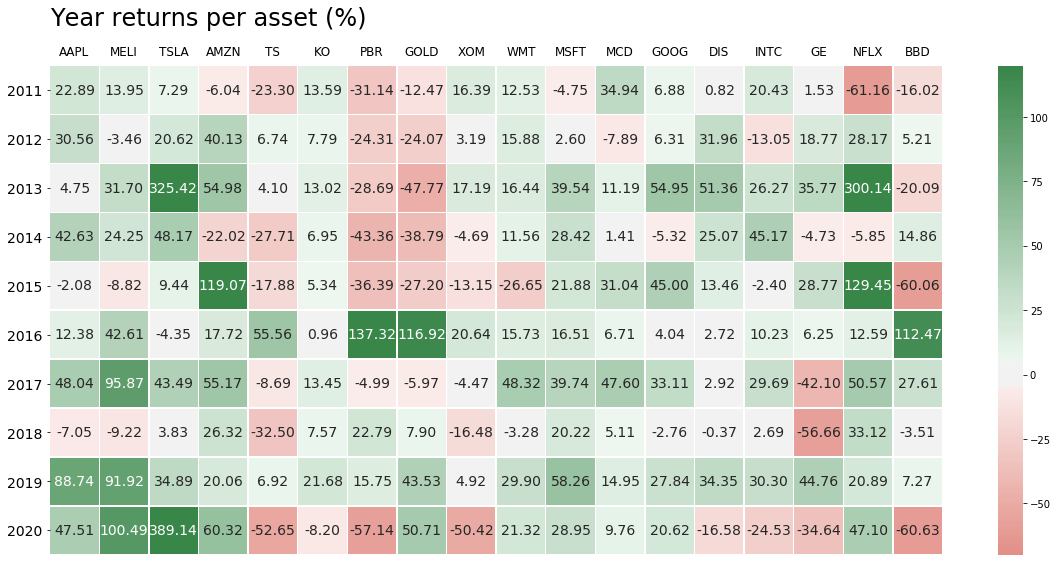

In [228]:
cmap = sns.diverging_palette(h_neg=15, h_pos=133, as_cmap=True)
fig5 = plt.figure(figsize=(20,9))
sns.heatmap(year_returns, annot = True, linewidths=.5, cmap=cmap, fmt='.2f', vmin=-70, vmax=120, center=0.0, annot_kws=dict(fontsize=14))
plt.title('Year returns per asset (%)', fontsize = 24, loc = 'left', pad=20)
plt.ylabel('', fontsize = 15)
plt.tick_params(axis='both', which='major', labelbottom = False, bottom=False, labeltop=True)
plt.xticks(rotation=0, fontsize = 12)
plt.yticks(rotation=0, fontsize = 14)

# Mean-variance optimization (MVO)

----

Markowitz (1952) derived the optimal rule for allocating wealth across risky assets in a static setting when investors care only about the mean and variance of a portfolio’s return.

That rule consists on finding the weights for each risky asset that minimize the portfolio risk (given by it standard deviation) subject to a certain expected return. This allows as to derivate the efficient frontier, but what of all the different points that form that frontier are we interested on? Given a risk free rate, we can find the "tangency porfolio" which is the porfolio with the maximum Sharpe ratio. This tangency porfolio is the one that will give as the optimal weights for each risky asset.

Because the Markowitz formulation captures two fundamental aspects of portfolio choice – diversification and the trade-off between risk and return – in an analytically tractable and easily extendable framework, it has become a standard in the financial profession. There are, however, some important objections to the mean-variance framework. First, Markowitz framework ignores preferences towards higher moments, which can be economically non-negligible. Asset returns, in particular, can be skewed and have excess kurtosis sufficiently large to invalidate the mean-variance framework. Secondly, and more important, we do not know the first two moments of returns, so we have to rely on their sample estimations. These estimations naturally have measurement error, which makes MVO perform poorly out of sample. 

Let's first solve the static Markowitz formulation.

In [6]:
data['Tbill'] = (yf.download('^IRX', start = '2011-01-01')['Adj Close'])/100
data.fillna(method = 'ffill')

Tbill = pd.Series(data['Tbill'])

data.drop('Tbill', axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed


In [7]:
rets = data.pct_change()

In [8]:
noa = len(rets.columns)
rets_mean= (1 + rets.mean())**252 -1
sigma = rets.cov() * 252
Rf = Tbill[-1]

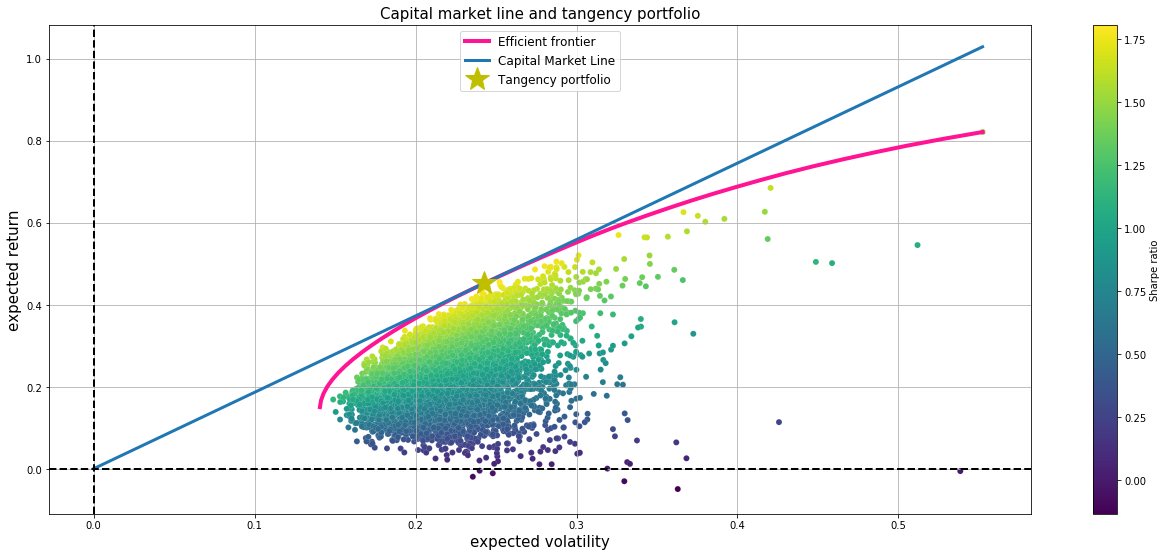

In [9]:
opt, exp_rets, exp_vol = port_opt(rets_mean, sigma, noa, Rf)

In [10]:
print('The optimal weights are:')
opt

The optimal weights are:


{'AAPL': 0.148387,
 'MELI': 0.08845,
 'TSLA': 0.225173,
 'AMZN': 0.18183,
 'TS': 0.0,
 'KO': 0.0,
 'PBR': 0.0,
 'GOLD': 0.015637,
 'XOM': 0.0,
 'WMT': 0.158289,
 'MSFT': 0.024527,
 'MCD': 0.056304,
 'GOOG': 0.0,
 'DIS': 0.0,
 'INTC': 0.0,
 'GE': 0.0,
 'NFLX': 0.101404}

In [11]:
print('The expected return of the porfolio is ' + str(np.round(exp_rets,4)*100) +'%')
print('The expected volatility of the porfolio is ' + str(np.round(exp_vol,4)*100) +'%')

The expected return of the porfolio is 45.26%
The expected volatility of the porfolio is 24.26%


## Ex-post performance of the MVO
_______

The above is an static optimization that uses the whole sample to estimate the moments. But we cannot test the performance of such porfolio. For that purpose, let's perform the following excercise:

1. We choose a date in which we want to optimize our portfolio.
2. We estimate the two moments needed (mean and variance) using from the previous 60 months (1260 days). This time window is decided based on DeMiguel et al (2007).
3. We use the obtained optimal weights to form our portfolio and we mantain it for the next year.
4. We compare the expected returns and volatility with the observed ones.


### Rolling window moments

In [12]:
rets_rw_mean = np.round(rets.rolling(1260).mean()*252, 4).dropna()
rets_rw_cov = np.round(rets.rolling(1260).cov() * 252,4).dropna()

### Select a day for the optimization

In [15]:
year = int(input('Year (from 2016 to one year ago): '))
month = int(input('Month: '))
day = int(input('Day: '))
date= datetime(year, month, day)

try:
    t = rets_rw_mean.index.get_loc(date)
except KeyError:
    print('The selected is a non-business day. Try again')

Year (from 2016 to one year ago): 2016
Month: 7
Day: 7


In [16]:
noa = len(rets.columns)
rets_mean=rets_rw_mean.iloc[t]
sigma = rets_rw_cov.loc[rets_rw_mean.index[t]]
Rf = Tbill[rets_rw_mean.index[t]]

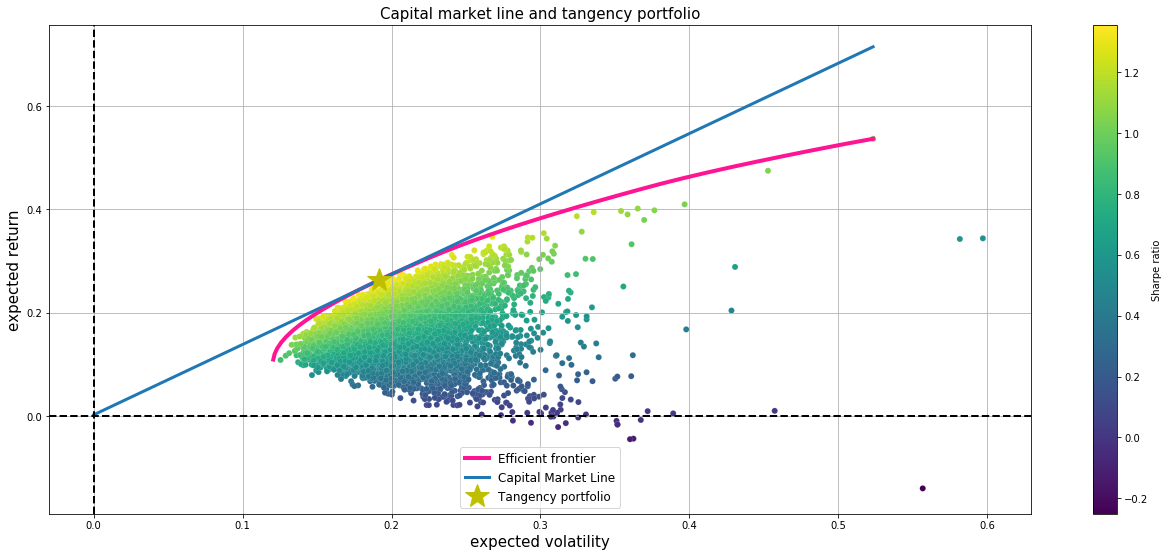

In [17]:
opt, exp_rets, exp_vol = port_opt(rets_mean, sigma, noa, Rf)
opt_weights = list(opt.values())

In [19]:
print('The optimal weights on '+ str(date.date())+ ' are:')
opt

The optimal weights on 2016-07-07 are:


{'AAPL': 0.065017,
 'MELI': 0.0,
 'TSLA': 0.171984,
 'AMZN': 0.128032,
 'TS': 0.0,
 'KO': 0.0,
 'PBR': 0.0,
 'GOLD': 0.0,
 'XOM': 0.0,
 'WMT': 0.110635,
 'MSFT': 0.046165,
 'MCD': 0.097423,
 'GOOG': 0.102119,
 'DIS': 0.248691,
 'INTC': 0.0,
 'GE': 0.0,
 'NFLX': 0.029933}

### Ex-post performance

In [20]:
print(' - The expected return of the optimization is ' + str(exp_rets.round(4)))
print(' - The expected volatility of the optimization is ' + str(exp_vol.round(4)))
print(' - The expected Sharpe ratio of the optimization is ' + str(((exp_rets - Rf)/exp_vol).round(4)))

 - The expected return of the optimization is 0.2627
 - The expected volatility of the optimization is 0.1912
 - The expected Sharpe ratio of the optimization is 1.3596


In [21]:
ret_expost = np.dot(opt_weights, ((rets[rets_rw_mean.index[t]:rets_rw_mean.index[t+251]] +1).rolling(252).apply(np.prod)-1).dropna().T)[0]
vol_expost= np.sqrt(np.dot(opt_weights, np.dot(rets_rw_cov.loc[rets_rw_mean.index[251 + t]], opt_weights)))

In [22]:
print(' - The ex-post return of the optimization is ' + str(ret_expost.round(4))) 
print(' - The ex-post volatility of the optimization is ' + str(vol_expost.round(4)))
print(' - The ex-post Sharpe ratio of the optimization is ' + str(((ret_expost - Rf)/vol_expost).round(4)))

 - The ex-post return of the optimization is 0.2669
 - The ex-post volatility of the optimization is 0.1646
 - The ex-post Sharpe ratio of the optimization is 1.6053


# Enhanced portfolio optimization (EPO)

__________

Motivated by the poor finite-sample properties of plug-in estimates, there exists an extensive literature suggesting different methods to reduce the impact of estimation error.

One of them is the Ledoit and Wolf (2003, 2004) aproach. The authors propose a method for reducing the estimation error in the covariance matrix by using a weighted average of the sample covariance matrix and another structured estimator.

Babu, A., Levine, A. and Pedersen, L. H.(2020) explain the reasons for the poor performance of the MVO. They state that partly due to measurement errors, the risk model may imply that certain portfolios have little risk at a given time, and nothing ensures that the estimated expected return of these portfolios is correspondingly small. Hence, these portfolios appear to have sizeable Sharpe ratios (SRs) driven by noise, which is the source of trouble for MVO. Indeed, MVO seeks to take sizeable risk in such portfolios with sizeable estimated SRs, and, to achieve this, the optimizer takes large notional positions. These large notional positions are problematic because the true SRs of these noise-driven portfolios are usually much lower.

What are these problem portfolios? If we transform the standard optimization problem into the space of principal components, we can work with portfolios that are uncorrelated with each other and ranked by their importance, namely their variance. Working with principal components greatly simplifies the diagnosis of the problems with standard MVO, since principal components are by definition uncorrelated, which in turn means that the risk that MVO takes in each principal component is simply proportional to its Sharpe ratio. The least important principal components are exactly the portfolios that cause trouble for the standard MVO. Indeed, these portfolios have the lowest estimated risk and, as a result, their risks tend to be slightly underestimated.

Having identified the problem portfolios, how can we address the problem. The solution is to reduce the estimated Sharpe ratios of the least important principal components. Reducing estimated Sharpe ratios of the least important principal components can be achieved by increasing their estimated volatilities. 

Babu et al (2020) show that adjusting the volatilities of PC portfolios corresponds to adjusting the correlations of the original assets. Specifically, increasing the volatility of problem portfolios while lowering the volatility of the important PC portfolios is the same as multiplying all the correlations of the original assets by $1−\theta$.

This is why Ledoit and Wolf (2003) propose a new formula for estimating the covariance matrix of stock returns that can benefficially replace the sample covariance matrix in any mean-variance optimization application. They call it the **shrinkage** of the covariance matrix. If properly implemented, this shrinkage could fix the problem of the sample covariance matrix.

The essential idea is that the unbiased but poorly estimated sample covariance can be combined with a structured estimator $F$, using the below formula (where $\delta$ is the shrinkage constant and $S$ is the sample covariance matrix):

$$ \hat{\Sigma} = \delta F +(1-\delta)S$$

It is called shrinkage because it can be thought of as “shrinking” the sample covariance matrix towards the other estimator, which is accordingly called the shrinkage target. The shrinkage target may be significantly biased but has little estimation error. There are many possible options for the target, and each one will result in a different optimal shrinkage constant $\delta$. 

## Principal Component Analysis

In [23]:
from sklearn.decomposition import PCA

pca = PCA(n_components = noa)
principalDF_exa = pd.DataFrame(pca.fit_transform(rets.dropna()[0:1260]), 
                           index = rets.dropna().index[0:1260])

loadings_exa = pd.DataFrame(pca.components_.T, index = rets.columns)

var_exa = pca.explained_variance_ratio_
var_factors_exa = {'Factors':[str(i) for i in range(1, noa+1)],
               'Variance': [var_exa[i] for i in range(noa)]}

In [24]:
pca = PCA(n_components = noa)
principalDF_exp = pd.DataFrame(pca.fit_transform(rets.dropna()[1260:]), 
                           index = rets.dropna().index[1260:])

loadings_exp = pd.DataFrame(pca.components_.T, index = rets.columns)

var_exp = pca.explained_variance_ratio_
var_factors_exp = {'Factors':[str(i) for i in range(1, noa+1)],
               'Variance': [var_exp[i] for i in range(noa)]}

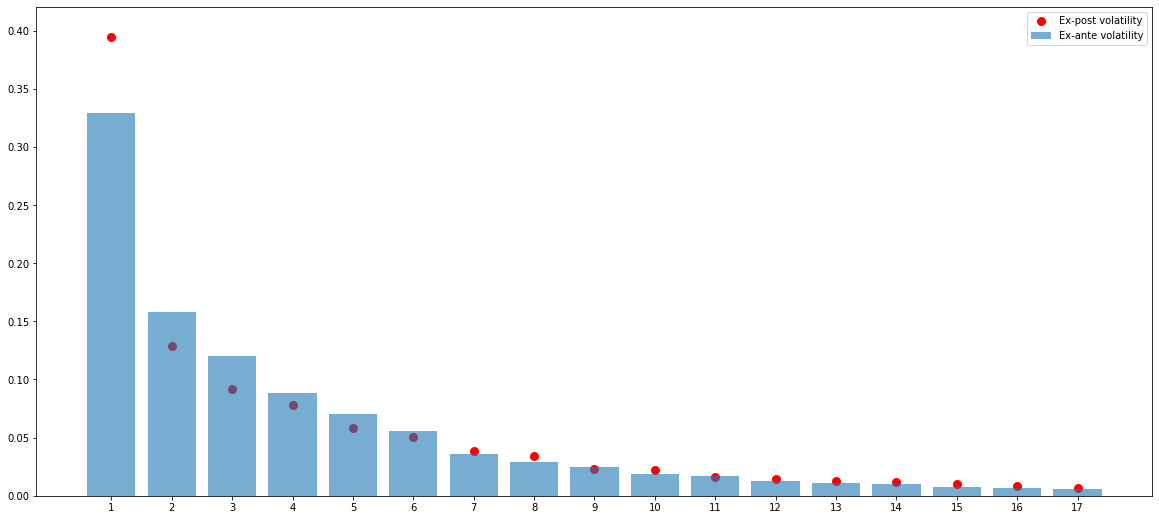

In [25]:
fig = plt.figure(figsize = (20,9))
plt.scatter(var_factors_exp['Factors'], var_factors_exp['Variance'], color = 'red', lw=3, label ='Ex-post volatility')
plt.bar(var_factors_exa['Factors'], var_factors_exa['Variance'], label = 'Ex-ante volatility', alpha = 0.6)
plt.legend(loc = 'upper right')

By construction, PC #1 has the highest volatility and PC #17 has the lowest volatility. Looking at the realized volatilities of these portfolios, we see that the realized returns are also decreasing in the PC number with volatility levels that roughly match their average ex ante counterparts, reflecting that the risk model works reasonably well. However, we do see systematic errors: the least important PCs (those with highest numbers) have higher realized volatilities than their average ex ante volatility. This is due to the fact that these portfolios have been chosen as those with the lowest ex ante volatility so errors in the risk model may lead to underestimation of the ex ante risk of these portfolios.

Problem portfolios are the least important principal components, and we can mitigate the under-estimation of their risk simply by shrinking correlations.

## Shinkage of the correlation matrix

We will make use of the **PyPortfolioOpt** library, which not only allows us to perform the standard MVO formulation, but also the EPO approach.

In [26]:
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

In [27]:
sigma = rets.cov() * 252
sigma_shrinked = CovarianceShrinkage(data).ledoit_wolf(shrinkage_target='constant_correlation')
mu = rets.mean()*252

In [28]:
ef = EfficientFrontier(mu, sigma_shrinked)
w = ef.max_sharpe(risk_free_rate=Tbill[-1])

In [29]:
cleaned_weights = ef.clean_weights()
print(cleaned_weights)

OrderedDict([('AAPL', 0.15166), ('MELI', 0.0709), ('TSLA', 0.15126), ('AMZN', 0.1724), ('TS', 0.0), ('KO', 0.0), ('PBR', 0.0), ('GOLD', 0.01733), ('XOM', 0.0), ('WMT', 0.1823), ('MSFT', 0.06156), ('MCD', 0.11136), ('GOOG', 0.0), ('DIS', 0.0), ('INTC', 0.0), ('GE', 0.0), ('NFLX', 0.08122)])


In [30]:
ef.portfolio_performance(verbose=True)

Expected annual return: 32.0%
Annual volatility: 21.3%
Sharpe Ratio: 1.41


(0.32014480026979203, 0.21334340448697992, 1.4068623353580612)

We can even find the quantity of each stock we should buy based on the latest prices and the amount of the investment.

In [31]:
latest_prices = get_latest_prices(data)
da = DiscreteAllocation(w, latest_prices, total_portfolio_value=10000)
allocation, leftover = da.lp_portfolio()
print(allocation)
print("Leftover", leftover)

{'AAPL': 12, 'TSLA': 3, 'AMZN': 1, 'GOLD': 5, 'WMT': 12, 'MSFT': 2, 'MCD': 5, 'NFLX': 1}


## Naive portfolio

The strategy of investing an equal portion of total wealth in each risky asset (that is: $w_i = 1/N$) does not involve any optimization or estimation and completely ignores the data. Yet, there is strong empirical evidence that the naive equally-weighted portfolios outperform those obtained by optimization like MVO or EOP(see DeMiguel, Garlappi and Uppal (2007)). Besides, Benartzi and Thaler (2001) find that investors tend to allocate their wealth equally across assets. We will then analize this heuristic rule as well.

----
# Comparing MVO, EPO and naive strategies

In order to compare the out-of-sample performance of the three aforementioned asset allocation strategies, we will use a “rolling sample” methodology similar to DeMiguel, Garlappi and Uppal (2007).That rolling window consists in 1260 trading days, which corresponds to 60 months. This aproach has several steps:

1. For each asset allocation strategy we will then the optimization the day $t = 1260$. Using the information of the 1260 previous day, we estimate the moments required in each strategy.

2. Using the estimated moments, we perform each strategy and obtain a vector of optimal weights for each risky asset.

3. These weights are used to construct our porfolio, which we will mantain for the next 21 days. Then we will computed the actual return and volatility of the portfolio.

4. On day 22, we rebalance the optimal weights. We go back to step one and keep doing so until we reach the end of the data set.

## 1. MVO strategy

In [32]:
S = rets.rolling(1260).cov().dropna()* 252
M = rets.rolling(1260).mean().dropna()*252

In [33]:
dyn_weights_mvo = pd.DataFrame(columns = rets.columns, index = [z for z in range (0, len(M), 21)])
expected_moments_mvo = pd.DataFrame(columns = ['E(r)', 'SD(r)', 'SR'], index = [z for z in range (0, len(M), 21)])

for t in range(0, len(M), 21):
    mu = M.iloc[t]
    sigma = S.loc[M.index[t]]
    ef = EfficientFrontier(mu, sigma)
    w = ef.max_sharpe(risk_free_rate=Tbill[t+1260])
    wt = list(w.values())
    dyn_weights_mvo.loc[t] = wt
    expected_moments_mvo.loc[t] = ef.portfolio_performance()

Text(0.5, 1.0, 'Dynamic weights (rebalanced every 21 days)')

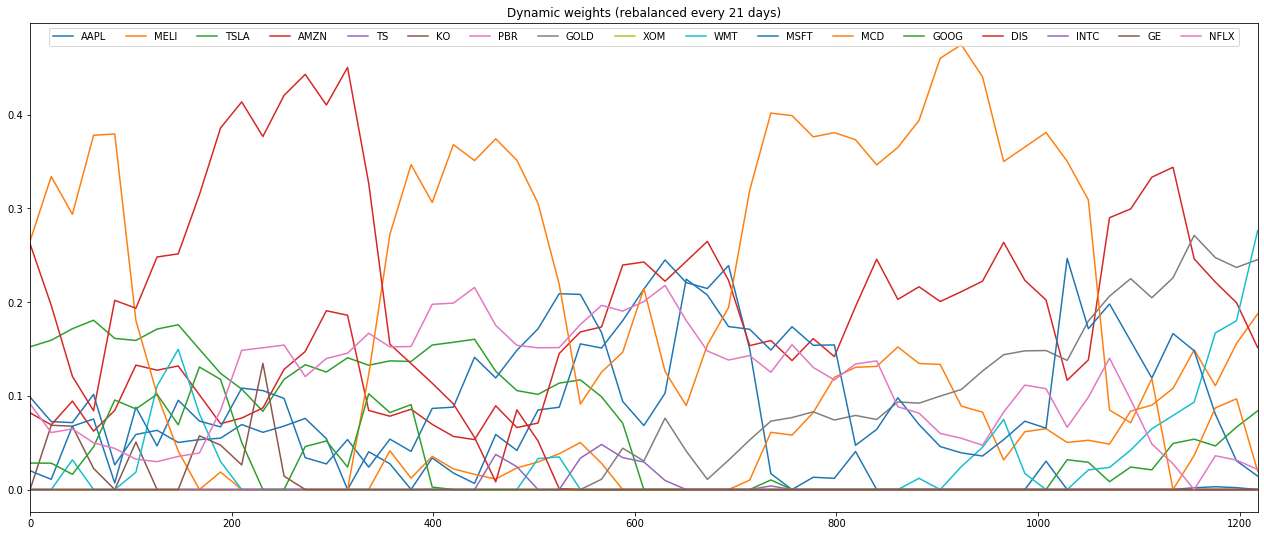

In [34]:
fig = plt.figure(figsize = (22,9))
plt.plot(dyn_weights_mvo)
plt.legend(dyn_weights_mvo.columns.values, loc = 'upper center',  ncol=len(dyn_weights_mvo.columns))
plt.autoscale(tight = True, axis = 'x')
plt.title('Dynamic weights (rebalanced every 21 days)')

In [35]:
performed_moments_mvo = pd.DataFrame(columns = ['Returns', 'Volatility', 'SR'], index= expected_moments_mvo.index)

In [36]:
rets_21 = (rets[1261:].groupby(rets[1261:].reset_index().index // 21)).sum()

In [37]:
for i in range(len(rets_21)):
    performed_moments_mvo['Returns'].iloc[i] = (dyn_weights_mvo.iloc[i]* rets_21.iloc[i]).sum()*252/21

Text(0.5, 1.0, 'Expected vs observed returns - MVO strategy')

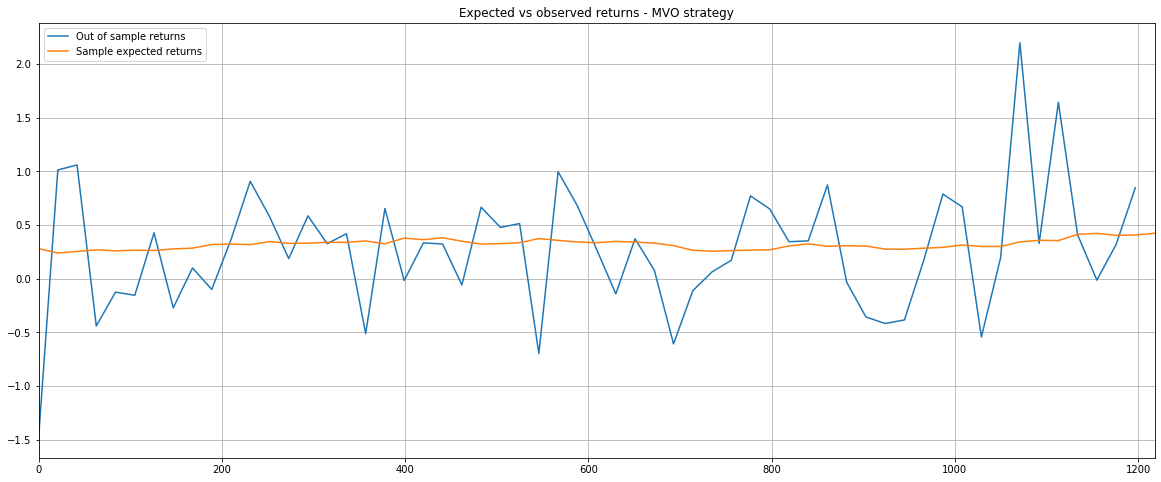

In [56]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_mvo['Returns'], label = 'Out of sample returns')
plt.plot(expected_moments_mvo['E(r)'], label = 'Sample expected returns')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Expected vs observed returns - MVO strategy')

In [39]:
cov_21 = rets[1261:].groupby(rets[1261:].reset_index().index // 21).cov()

for i in range(len(rets_21)):
    performed_moments_mvo['Volatility'].iloc[i] = np.sqrt(dyn_weights_mvo.iloc[i].dot(cov_21.loc[i].dot(dyn_weights_mvo.iloc[i])) * 252)

Text(0.5, 1.0, 'Expected vs observed volatility- MVO strategy')

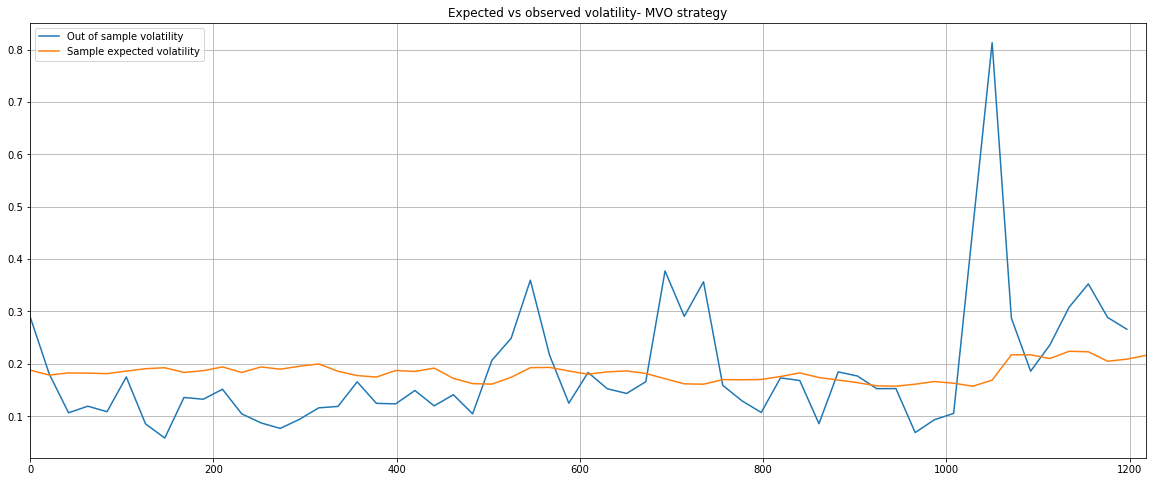

In [57]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_mvo['Volatility'], label = 'Out of sample volatility')
plt.plot(expected_moments_mvo['SD(r)'], label = 'Sample expected volatility')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Expected vs observed volatility- MVO strategy')

In [44]:
performed_moments_mvo['risk free rate'] = [Tbill[x + 1260] for x in performed_moments_mvo.index.values]

In [45]:
performed_moments_mvo['SR'] = (performed_moments_mvo['Returns'] - performed_moments_mvo['risk free rate'])/ performed_moments_mvo['Volatility']

Text(0.5, 1.0, 'Expected vs observed Sharpe ratio- MVO strategy')

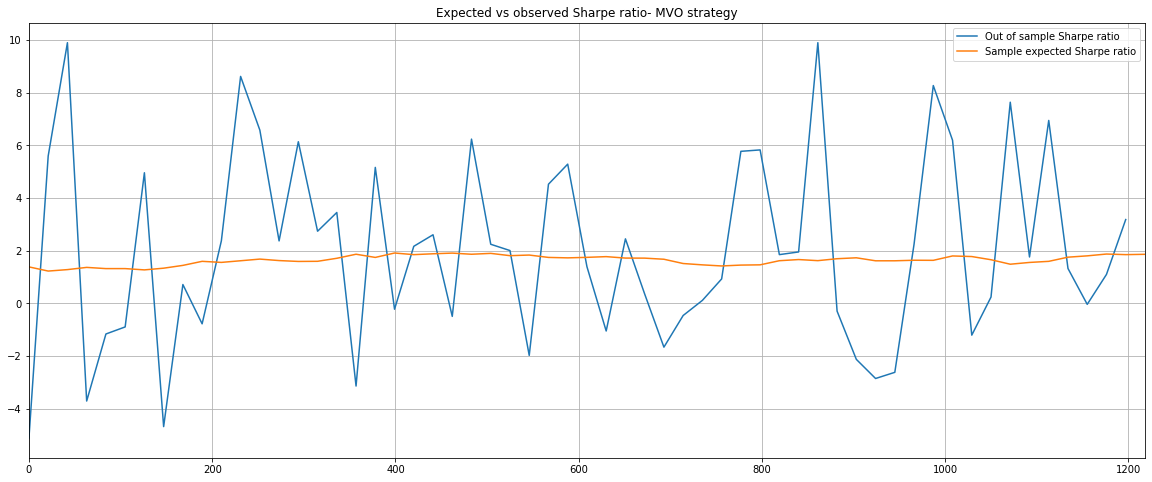

In [58]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_mvo['SR'], label = 'Out of sample Sharpe ratio')
plt.plot(expected_moments_mvo['SR'], label = 'Sample expected Sharpe ratio')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Expected vs observed Sharpe ratio- MVO strategy')

## 2. EPO strategy

In [47]:
tool_sigma = rets.rolling(1260).cov().dropna()

In [48]:
M = rets.rolling(1260).mean().dropna()*252

S_shrinked = pd.DataFrame(columns = rets.columns, index = tool_sigma.index)
for t in range(0,len(M)):
    S_shrinked[t*noa:(t+1)*noa] = CovarianceShrinkage(data[t: t + 1260]).shrunk_covariance(delta = 0.5).values

In [49]:
dyn_weights_epo = pd.DataFrame(columns = rets.columns, index = [z for z in range (0, len(M), 21)])
expected_moments_epo = pd.DataFrame(columns = ['E(r)', 'SD(r)', 'SR'], index = [z for z in range (0, len(M), 21)])

for t in range(0, len(M), 21):
    mu = M.iloc[t]
    sigma = S_shrinked.loc[M.index[t]]
    ef = EfficientFrontier(mu, sigma)
    w = ef.max_sharpe(risk_free_rate=Tbill[t+1260])
    wt = list(w.values())
    dyn_weights_epo.loc[t] = wt
    expected_moments_epo.loc[t] = ef.portfolio_performance()

In [50]:
performed_moments_epo = pd.DataFrame(columns = ['Returns', 'Volatility', 'SR'], index= expected_moments_epo.index)
rets_21 = (rets[1261:].groupby(rets[1261:].reset_index().index // 21)).sum()
for i in range(len(rets_21)):
    performed_moments_epo['Returns'].iloc[i] = (dyn_weights_epo.iloc[i]* rets_21.iloc[i]).sum()*252/21

Text(0.5, 1.0, 'Expected vs observed returns- EPO strategy')

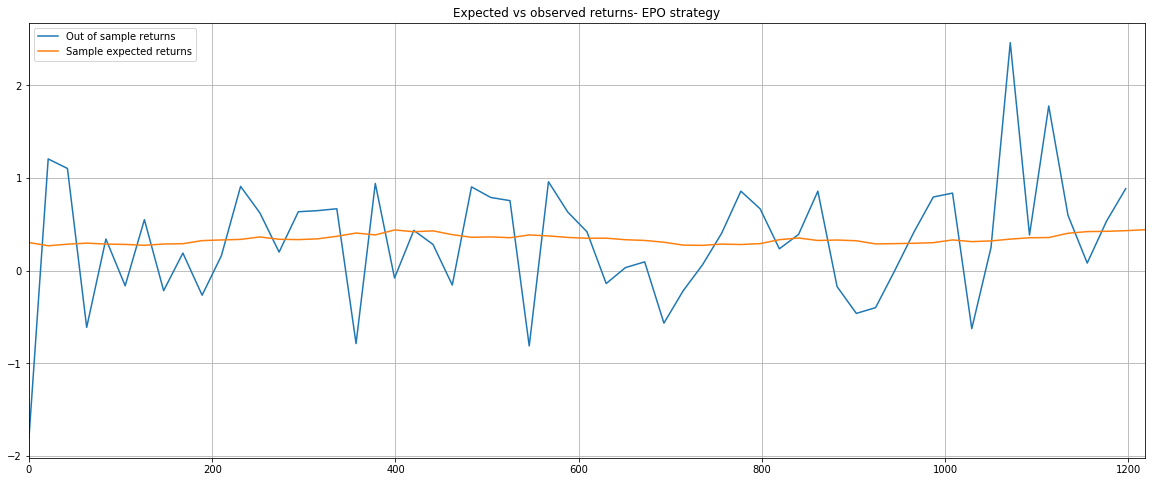

In [59]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_epo['Returns'], label = 'Out of sample returns')
plt.plot(expected_moments_epo['E(r)'], label = 'Sample expected returns')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Expected vs observed returns- EPO strategy')

In [52]:
cov_21 = rets[1261:].groupby(rets[1261:].reset_index().index // 21).cov()

for i in range(len(rets_21)):
    performed_moments_epo['Volatility'].iloc[i] = np.sqrt(dyn_weights_epo.iloc[i].dot(cov_21.loc[i].dot(dyn_weights_epo.iloc[i])) * 252)

Text(0.5, 1.0, 'Expected vs observed volatility - EPO strategy')

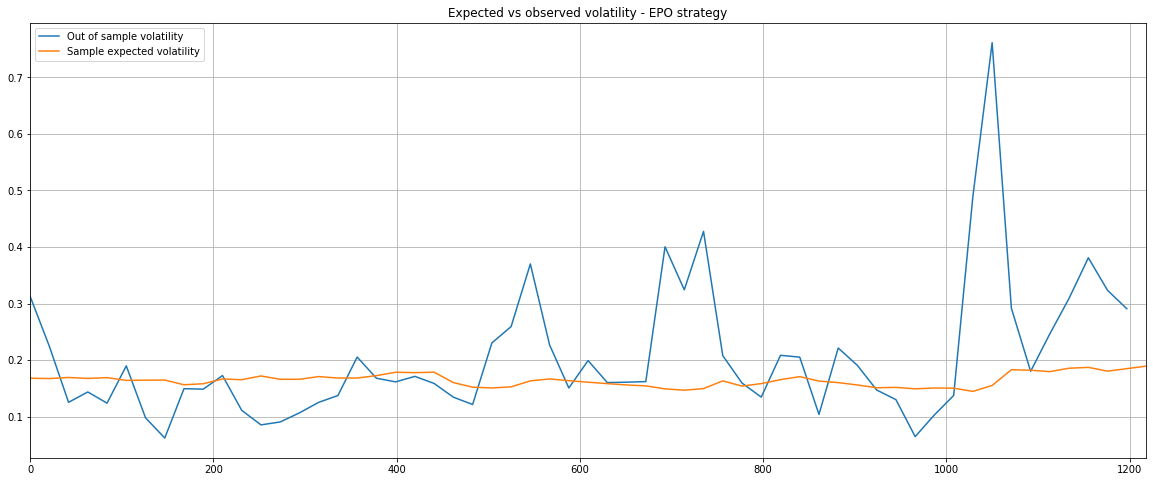

In [60]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_epo['Volatility'], label = 'Out of sample volatility')
plt.plot(expected_moments_epo['SD(r)'], label = 'Sample expected volatility')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Expected vs observed volatility - EPO strategy')

In [61]:
performed_moments_epo['risk free rate'] = [Tbill[x + 1260] for x in performed_moments_epo.index.values]

performed_moments_epo['SR'] = (performed_moments_epo['Returns'] - performed_moments_epo['risk free rate'])/ performed_moments_epo['Volatility']

Text(0.5, 1.0, 'Expected vs observed Sharpe ratio')

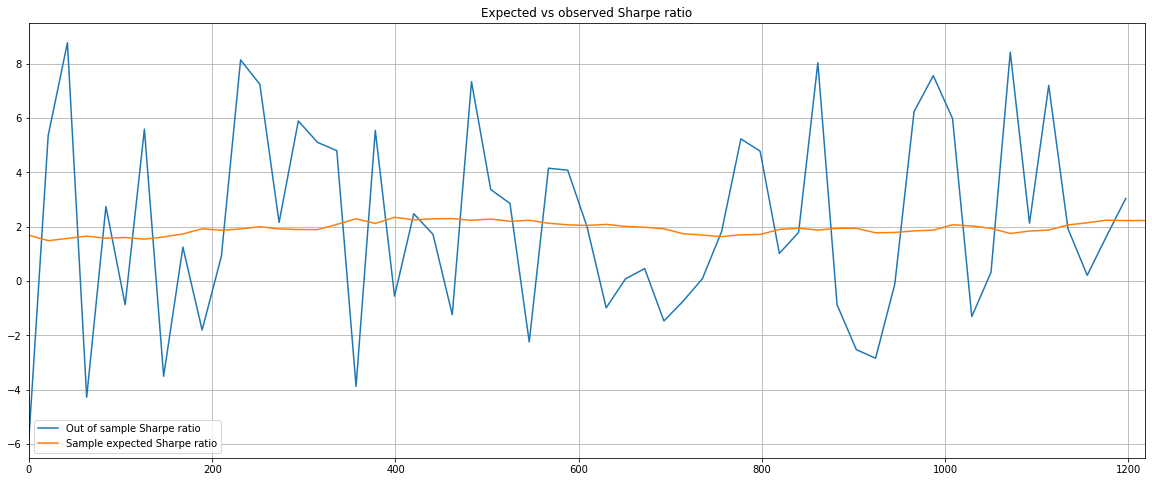

In [62]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_epo['SR'], label = 'Out of sample Sharpe ratio')
plt.plot(expected_moments_epo['SR'], label = 'Sample expected Sharpe ratio')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Expected vs observed Sharpe ratio  - EPO strategy')

Text(0.5, 1.0, 'MVO vs EPO returns')

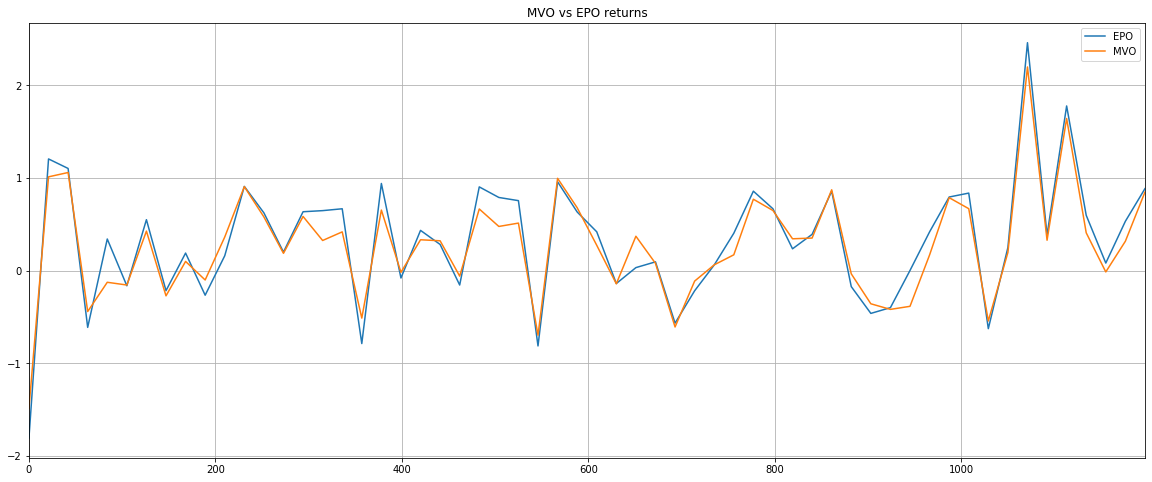

In [64]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_epo['Returns'], label = 'EPO')
plt.plot(performed_moments_mvo['Returns'], label = 'MVO')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('MVO vs EPO returns')

## 3. Naive strategy

In [65]:
naive_weights = np.array(noa * [1 / noa,])

In [67]:
performed_moments_naive = pd.DataFrame(columns = ['Returns', 'Volatility', 'SR'], index= expected_moments_epo.index)
rets_21 = (rets[1261:].groupby(rets[1261:].reset_index().index // 21)).sum()
for i in range(len(rets_21)):
    performed_moments_naive['Returns'].iloc[i] = (naive_weights[0]* rets_21.iloc[i]).sum()*252/21

In [68]:
cov_21 = rets[1261:].groupby(rets[1261:].reset_index().index // 21).cov()

for i in range(len(rets_21)):
    performed_moments_naive['Volatility'].iloc[i] = np.sqrt(naive_weights.dot(cov_21.loc[i].dot(naive_weights)) * 252)

In [69]:
performed_moments_naive['risk free rate'] = [Tbill[x + 1260] for x in performed_moments_naive.index.values]

performed_moments_naive['SR'] = (performed_moments_naive['Returns'] - performed_moments_naive['risk free rate'])/ performed_moments_naive['Volatility']

Text(0.5, 1.0, 'MVO vs EPO Sharpe ratio')

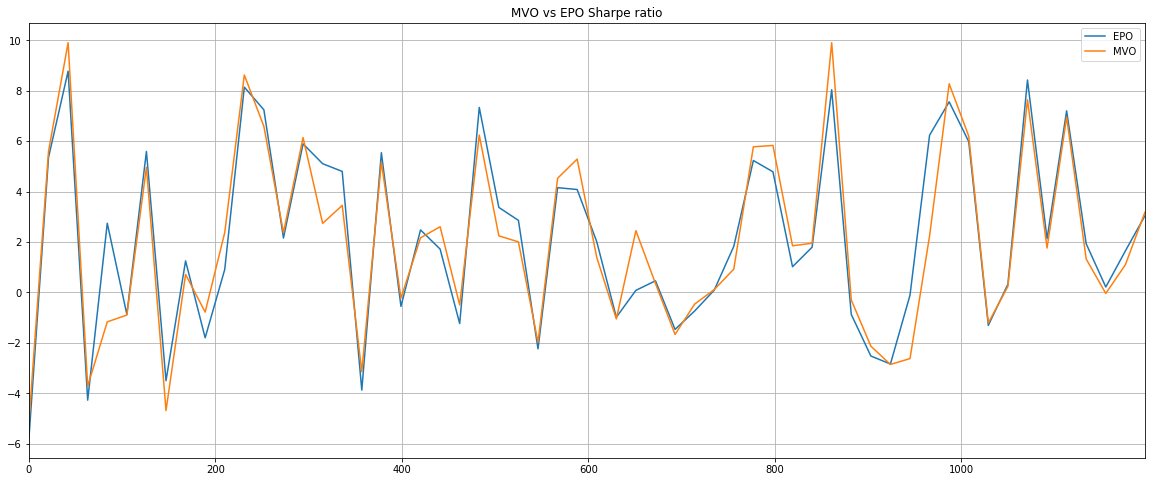

In [70]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_epo['SR'], label = 'EPO')
plt.plot(performed_moments_mvo['SR'], label = 'MVO')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('MVO vs EPO Sharpe ratio')

Text(0.5, 1.0, 'Naive vs EPO Sharpe ratio')

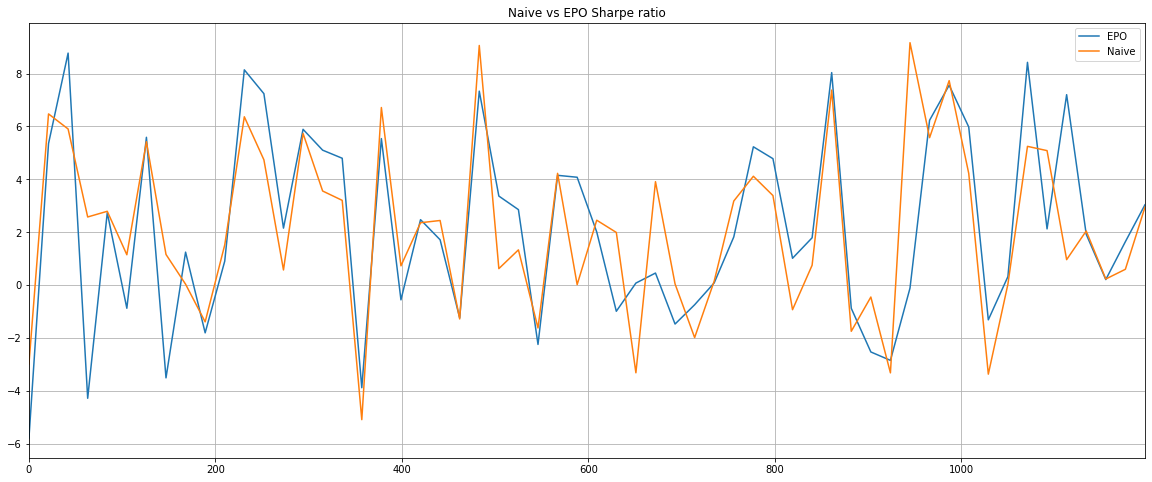

In [71]:
fig = plt.figure(figsize = (20,8))
plt.plot(performed_moments_epo['SR'], label = 'EPO')
plt.plot(performed_moments_naive['SR'], label = 'Naive')
plt.legend(loc = 'best')
plt.autoscale(axis = 'x', tight = True)
plt.grid(True)
plt.title('Naive vs EPO Sharpe ratio')

## Performance measures

The above figures are not very clarifying respect to which is the best strategy. To compare the out-of-sample performance of the different strategies, we can compute three different performance measures: the out-of-sample Sharpe ratio, the certainty-equivalent return and the portfolio turnover.

#### Sharpe ratio

The out-of-sample Sharpe ratio for strategy is defined as the sample mean of the out-of-sample excess returns, divided by their sample standard deviation:

$$\hat{SR_j} = \dfrac{\hat{\mu_j}}{\hat{\sigma_j}}$$


#### Certainty equivalent return (CEQ)

The certainty-equivalent return for strategy j is the risk-free rate of return that the investor is willing to accept instead of undertaking the risky portfolio strategy. In the literature on portfolio construction it is common to mathematically define the certainty-equivalent return as:

$$\hat{CEQ_j} = \hat{\mu} - \dfrac{\hat{\gamma}}{2}\hat{\sigma}^2$$

where $\hat{\mu}$ and $\hat{\sigma}^2$ are the mean and variance of the out-of-sample excess returns for strategy j, and $\hat{\gamma}$ is the investor's risk aversion. We will assume $\hat{\gamma} =1$.


#### Turnover

The third measure of out-of-sample performance is portfolio turnover. This is a volume-based measure of the amount of trading required to implement a particular portfolio strategy. Turnover for strategy k is defined as the average sum of the absolute value of trades across the N risky assets:
Let M be the amount of rebalance of the strategy ($M = (T-1260)/21$):

$$Turnover_k = \dfrac{1}{M} \sum_{t=1}^M \sum_{j=1}^N (|\omega_{k,j,t+1} - \omega_{k,j,t+}|)$$

where $\omega_{k,j,t}$ is the portfolio weight in asset j at time t according to strategy k. The optimal weight in time t+1 is $\omega_{k,j,t+1}$ , and the actual weight in asset j before rebalancing at time t+1 is $\omega_{k,j,t+}$ . For example, for the equally weighted portfolio both $\omega_{k,j,t}$ and $\omega_{k,j,t+1}$ equal $1/N$, but the weights before rebalancing are different due to changes in prices.

In [72]:
sr_mvo = (performed_moments_mvo['Returns']-performed_moments_mvo['risk free rate']).mean()/performed_moments_mvo['Returns'].std()
sr_epo = (performed_moments_epo['Returns']-performed_moments_epo['risk free rate']).mean()/performed_moments_epo['Returns'].std()
sr_naive = (performed_moments_naive['Returns']-performed_moments_naive['risk free rate']).mean()/performed_moments_naive['Returns'].std()

In [73]:
ceq_mvo = (performed_moments_mvo['Returns']-performed_moments_mvo['risk free rate']).mean() - performed_moments_mvo['Returns'].var()/2
ceq_epo = (performed_moments_epo['Returns']-performed_moments_epo['risk free rate']).mean() - performed_moments_epo['Returns'].var()/2
ceq_naive = (performed_moments_naive['Returns']-performed_moments_naive['risk free rate']).mean() - performed_moments_naive['Returns'].var()/2

In [74]:
price_changes = ((rets[1261:].groupby(rets[1261:].reset_index().index // 21)).sum()*252/21)+1

In [75]:
w_t_naive = pd.DataFrame(columns = price_changes.columns, index = price_changes.index)
for i in range(0, len(price_changes)):
    w_t_naive.iloc[i] = (naive_weights*price_changes.iloc[i])/(1 +performed_moments_naive['Returns'].iloc[i])
    
w_t_naive.fillna(naive_weights[0], inplace = True)    

In [76]:
w_t_mvo = pd.DataFrame(columns = price_changes.columns, index = price_changes.index)
for i in range(0, len(price_changes)):
    w_t_mvo.iloc[i] = (dyn_weights_mvo.iloc[i]*price_changes.iloc[i])/(1 +performed_moments_mvo['Returns'].iloc[i])
    
w_t_mvo.fillna(dyn_weights_mvo.iloc[0], inplace = True)

In [77]:
w_t_epo = pd.DataFrame(columns = price_changes.columns, index = price_changes.index)
for i in range(0, len(price_changes)):
    w_t_epo.iloc[i] = (dyn_weights_epo.iloc[i]*price_changes.iloc[i])/(1 +performed_moments_epo['Returns'].iloc[i])
    
w_t_epo.fillna(dyn_weights_epo.iloc[0], inplace = True)    

In [78]:
turnov_mvo = np.sum(np.sum(np.abs(dyn_weights_mvo.drop(0).values - w_t_mvo.values), axis=0), axis = 0)/len(w_t_mvo)
turnov_epo = np.sum(np.sum(np.abs(dyn_weights_epo.drop(0).values - w_t_epo.values), axis=0), axis = 0)/len(w_t_epo)
turnov_mvo = np.sum(np.sum(np.abs(w_t_naive.values - 1/noa), axis=0), axis = 0)/len(w_t_mvo)

In [79]:
performance_mvo = {'Sharpe ratio': np.round(sr_mvo,4),
                   'CEQ': np.round(ceq_mvo,4),
                   'Turnover': np.round(turnov_mvo,4)}
performance_epo = {'Sharpe ratio': np.round(sr_epo,4),
                   'CEQ': np.round(ceq_epo,4),
                   'Turnover': np.round(turnov_epo,4)}
performance_naive = {'Sharpe ratio': np.round(sr_naive,4),
                   'CEQ': np.round(ceq_naive,4),
                   'Turnover': np.round(turnov_mvo,4)}

In [140]:
rows = ['  MVO  ', '  EPO  ', '  Naive  ']
columns = list(performance_mvo.keys())
values = [list(performance_mvo.values()), list(performance_epo.values()), list(performance_naive.values())]

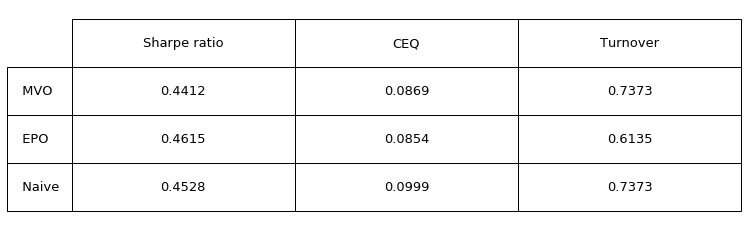

In [150]:
table = plt.table(values, rowLabels=rows, colLabels=columns, loc = 'center', cellLoc='center')
plt.axis('off')
table.scale(2, 4)
table.set_fontsize(13)

In terms of Sharpe ratio and turnover, the EPO is better. In terms of CEQ, the naive strategy outperforms the other two.